# EDA

This section is dedeicated to exploring the metadata of the raw data provided in the SOMOS dataset. This will help us get a sense for which features are provided and how the data was collected.

In the previous section we had laid out all of the features within this dataset, however I'll use this section to seperate out the most important features and evaluate the data we are given.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json

## Importing data

In [2]:
# SOMOS dataset
df_ai = pd.DataFrame(pd.read_csv('datasets/somos/raw_scores_with_metadata/raw_scores.tsv',sep="\t"))
df_ai

,utteranceId,choice,sentenceId,systemId,modelId,testpageId,locale,listenerId,isNative,wrongValidation,lowNatural,sameScores,highSynthetic,clean,listenerReliability
0,novel_2007_0098_015,4,novel_2007_0098,15,m1,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.0
1,reportorial_2011_0119_088,3,reportorial_2011_0119,88,m4,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.0
2,gt_LJ017-0230_000,5,LJ017-0230,0,m0,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.0
3,sus_2010_0026_109,4,sus_2010_0026,109,m4,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.0
4,novel_2007_0082_164,2,novel_2007_0082,164,m5,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374950,reportorial_2011_0096_197,4,reportorial_2011_0096,197,m5,999,us,LQWQ23271996857228,1,1,1,1,1,1,1.0
374951,gt_LJ039-0062_000,5,LJ039-0062,0,m0,999,us,LQWQ23271996857228,1,1,1,1,1,1,1.0
374952,LJ034-0086_086,4,LJ034-0086,86,m4,999,us,LQWQ23271996857228,1,1,1,1,1,1,1.0
374953,news_2011_0062_124,5,news_2011_0062,124,m4,999,us,LQWQ23271996857228,1,1,1,1,1,1,1.0


### Utterance Id

The utterance ID in the SOMOS dataset refers to a unique identifier assigned to each individual spoken utterance in the dataset. Within the dataset, there multiple recordings for each individual written scipt.

In [3]:
df_ai['utteranceId'].sort_values().head(5)

207611    LJ002-0181_033
207654    LJ002-0181_033
207724    LJ002-0181_033
207750    LJ002-0181_033
125861    LJ002-0181_033
Name: utteranceId, dtype: object

For each utterance shown above, there are 3 components which are shown as DDDD-NNNN-III

1. The first string, DDDD, corresponds to the base dataset that the SOMOS dataset used to create their audio files. In the case of LJ002, this corresponds to the LibriSpeech dataset and the 002 corresponds to the specific speaker for that file.
2. The second string, NNNN, corresponds with the section of script used as the source material for each utterance. Some of the datasets use audiobooks and this string would correspond to a section or chapter used.
3. The third string, III, indicates the utterance within the individual section provided within the second string

### Model ID and System ID

These features are of a particular importance as they indicate whether the utterance is computer generated or human. 'modelId' set will be our target variable for this analysis.

A modelId of 'm0' corresponds with human speech

In [4]:
df_ai[df_ai['modelId'] == 'm0'].value_counts().sum()

17855

The SOMOS dataset contains six different models (m0 through m6) that are used to generate audio data. m0 corresponds to human speech, while m1 through m6 correspond to different types of synthesized audio.

In [5]:
df_ai['modelId'].value_counts()

m5    128385
m4    116149
m3     73253
m1     32131
m0     17855
m2      7182
Name: modelId, dtype: int64

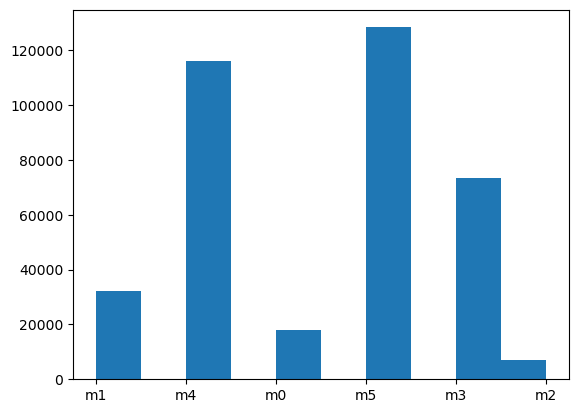

In [6]:
plt.hist(df_ai['modelId']);

The main difference between the models is the method used to synthesize the audio. Each model represents a different approach to audio synthesis, which can produce audio with different characteristics, such as speech quality, naturalness, and variability.

For example, m1 is a concatenative synthesis model, which uses pre-recorded speech segments to generate new speech. m2 is a neural vocoder model, which uses a neural network to model the spectral envelope of speech signals. m3 is a waveform concatenation model, which uses a modified version of the m1 model that concatenates speech segments at the waveform level.

The other models (m4 through m6) are variations or combinations of these basic approaches. For example, m4 is a hybrid concatenative-neural vocoder model that uses both concatenative and neural vocoder techniques to synthesize speech.

Which the models are numbered sequentially, the m1 model is not the predecessor to m2. Many the models were developed in parallel and they each represent a different path to modelling the available audio data

## Mean Opinion Score

A subset of the data provided within the SOMOS dataset is the Mean Opinion Score data (MOS) which has been provided in a seperate csv than the data shown above.

MOS is a metric that is commonly used in the field of speech quality evaluation to measure the overall quality of a speech signal, as perceived by human listeners.

To obtain a MOS rating, a group of human listeners are asked to listen to a speech signal and rate its overall quality on a scale of 1 to 5, with 1 indicating poor quality and 5 indicating excellent quality. The MOS is then calculated as the arithmetic mean of these individual ratings.

In the SOMOS dataset, MOS scores are provided for each utterance, indicating the perceived quality of the speech signal in that recording. MOS scores can be useful for evaluating the performance of speech recognition models, as they provide a measure of the accuracy and quality of the recognized speech output.

### Importing MOS Scores

In [7]:
df_mos = pd.read_csv('datasets/somos/training_files/split1/full/train_system.csv')

In [8]:
df_mos.head(5)

,systemId,mean
0,0,4.079747
1,3,3.683823
2,4,3.705058
3,5,3.505492
4,6,3.574285


To use this data, we'll join the MOS values on the systemId that we had previously discussed

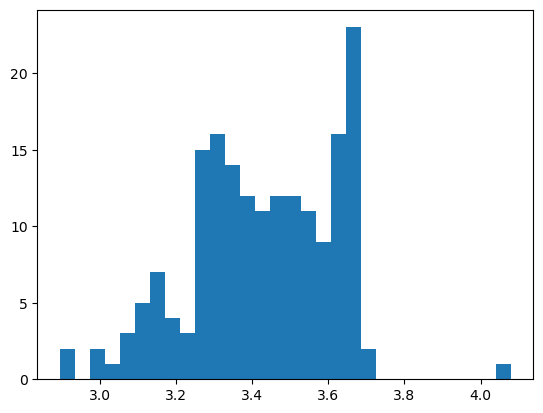

In [9]:
plt.hist(df_mos['mean'],bins = 30);

The distribution of the MOS values are less than normal and there is a gap within the range, indicating the majority of utterances were given a score between 3.3 and 3.7. Very few utterances were given a perfect score (5) or a score below a 3.

This tells us that we will likely not have to clean the audio before evaluating it. If there were a significant number of MOS values below 3, it would be important to clean the audio or to remove those utterances from the dataset entirely.

### Merging MOS & Raw Score Data

In [10]:
df = pd.merge(df_ai,df_mos, on = 'systemId')

In [11]:
df = df.rename(columns = {'mean':'MOS'}) 
df

,utteranceId,choice,sentenceId,systemId,modelId,testpageId,locale,listenerId,isNative,wrongValidation,lowNatural,sameScores,highSynthetic,clean,listenerReliability,MOS
0,novel_2007_0098_015,4,novel_2007_0098,15,m1,0,gb,KEXM49572020611127,1,1,1,1,1,1,1.00,3.590156
1,novel_2007_0098_015,2,novel_2007_0098,15,m1,0,gb,ONJP34545176526892,0,1,1,1,1,1,1.00,3.590156
2,novel_2007_0098_015,2,novel_2007_0098,15,m1,0,gb,BRHE82716530388427,1,1,1,1,1,1,1.00,3.590156
3,novel_2007_0098_015,5,novel_2007_0098,15,m1,0,gb,IJWO22856390758743,1,1,1,1,1,1,1.00,3.590156
4,novel_2007_0098_015,5,novel_2007_0098,15,m1,0,gb,BFXL60735888172229,1,0,0,1,0,0,0.46,3.590156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339203,reportorial_2011_0141_160,3,reportorial_2011_0141,160,m5,993,us,SQZP20987165412056,1,1,1,1,0,0,0.71,3.436844
339204,reportorial_2011_0141_160,4,reportorial_2011_0141,160,m5,993,us,VOPC28548555753770,1,1,1,1,0,0,0.29,3.436844
339205,reportorial_2011_0141_160,4,reportorial_2011_0141,160,m5,993,us,QQXJ36618242908678,1,1,0,1,0,0,0.32,3.436844
339206,reportorial_2011_0141_160,2,reportorial_2011_0141,160,m5,993,us,KRQC01203593359590,1,1,1,1,1,1,0.44,3.436844


## Pickles

In [12]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)